In [63]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import pandas as pd
import pickle
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.30'
jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_platform_name", "cpu")

os.chdir('/home/zongchen/chard/')

from kwgflows.rkhs.kernels import *
import ot
from kwgflows.divergences.mmd import *


plt.rcParams['axes.grid'] = False
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 20
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')

plt.rc('font', size=20)
plt.rc('lines', linewidth=2)
plt.rc('legend', fontsize=20, frameon=False)
plt.rc('xtick', labelsize=20, direction='in')
plt.rc('ytick', labelsize=20, direction='in')
plt.rc('figure', figsize=(9, 4))




In [64]:
def generate_three_ring_and_gaussian(seed, Nx, Ny):
    rng_key = jax.random.PRNGKey(seed)
    r, _delta = 0.3, 0.5
    
    X = jnp.c_[r * jnp.cos(jnp.linspace(0, 2 * jnp.pi, Nx + 1)), r * jnp.sin(jnp.linspace(0, 2 * jnp.pi, Nx + 1))][:-1]  # noqa
    for i in [1, 2]:
        X = jnp.r_[X, X[:Nx, :]-i*jnp.array([0, (2 + _delta) * r])]

    rng_key, _ = jax.random.split(rng_key)
    Y = jax.random.normal(rng_key, (Ny, 2)) / 100 - jnp.array([0, r])
    return X, Y

from numpyro import distributions as np_distributions

def generate_mog_and_gaussian(seed, Nx, Ny, mu, std):
    mixture_probs = jnp.array([0.25, 0.25, 0.25, 0.25])
    target_dist = np_distributions.MixtureSameFamily(
        mixing_distribution=np_distributions.Categorical(probs=mixture_probs),
        component_distribution=np_distributions.Normal(mu, std)
    )

    rng_key = jax.random.PRNGKey(seed)
    rng_key, _ = jax.random.split(rng_key)
    X = target_dist.sample(rng_key, (Nx,))

    rng_key, _ = jax.random.split(rng_key)
    source_dist = np_distributions.Independent(np_distributions.Normal(jnp.zeros((2,)), 0.1 * jnp.ones((2,))), 1)
    Y = source_dist.sample(rng_key, (Ny,))
    return X, Y, source_dist, target_dist

In [65]:
dataset = 'MixGaussian'

if dataset == 'MixGaussian':
    tikhonov_dir = '/home/zongchen/chard/results_new/MixGaussian_dataset/Gaussian_kernel/chard_spectral_flow/tikhonov_spectral/'
    tikhonov_hyper = ['lmbda_0.001_', 
                'bandwidth_2.0_',
                'step_num_10000_',
                'source_particle_num_300_',
                'opt_sgd_']
    tikhonov_trajectory = []
    tikhonov_config = []
    for file in os.listdir(tikhonov_dir):
        if all(hyper in file for hyper in tikhonov_hyper):
            tikhonov_trajectory.append(jnp.load(tikhonov_dir + file + '/Ys.npy'))
            tikhonov_config.append(pickle.load(open(tikhonov_dir + file + '/configs', 'rb')))
            
    if len(tikhonov_trajectory) == 0:
        raise ValueError('No tikhonov trajectory found')

    showalter_dir = '/home/zongchen/chard/results_new/MixGaussian_dataset/Gaussian_kernel/chard_spectral_flow/showalter_spectral/'
    showalter_hyper = ['lmbda_0.001_', 
                'bandwidth_2.0_',
                'step_num_10000_',
                'source_particle_num_300_',
                'opt_sgd_']
    showalter_trajectory = []
    showalter_config = []
    for file in os.listdir(showalter_dir):
        if all(hyper in file for hyper in showalter_hyper):
            showalter_trajectory.append(jnp.load(showalter_dir + file + '/Ys.npy'))
            showalter_config.append(pickle.load(open(showalter_dir + file + '/configs', 'rb')))
            
    if len(showalter_trajectory) == 0:
        raise ValueError('No tikhonov trajectory found')

    cutoff_dir = '/home/zongchen/chard/results_new/MixGaussian_dataset/Gaussian_kernel/chard_spectral_flow/cutoff_spectral/'
    cutoff_hyper = ['lmbda_1e-07_', 
                'bandwidth_2.0_',
                'step_num_10000_',
                'source_particle_num_300_',
                'opt_sgd_']
    cutoff_trajectory = []
    cutoff_config = []
    for file in os.listdir(cutoff_dir):
        if all(hyper in file for hyper in cutoff_hyper):
            cutoff_trajectory.append(jnp.load(cutoff_dir + file + '/Ys.npy'))
            cutoff_config.append(pickle.load(open(cutoff_dir + file + '/configs', 'rb')))
            
    if len(cutoff_trajectory) == 0:
        raise ValueError('No cutoff trajectory found')

elif dataset == 'ThreeRing':
    tikhonov_dir = '/home/zongchen/chard/results_new/ThreeRing_dataset/Gaussian_kernel/chard_spectral_flow/tikhonov_spectral/'
    tikhonov_hyper = ['lmbda_0.1_', 
                'bandwidth_0.15_',
                'step_num_10000_',
                'source_particle_num_300_',
                'opt_sgd_']
    tikhonov_trajectory = []
    tikhonov_config = []
    for file in os.listdir(tikhonov_dir):
        if all(hyper in file for hyper in tikhonov_hyper):
            tikhonov_trajectory.append(jnp.load(tikhonov_dir + file + '/Ys.npy'))
            tikhonov_config.append(pickle.load(open(tikhonov_dir + file + '/configs', 'rb')))
            
    if len(tikhonov_trajectory) == 0:
        raise ValueError('No tikhonov trajectory found')

    showalter_dir = '/home/zongchen/chard/results_new/ThreeRing_dataset/Gaussian_kernel/chard_spectral_flow/showalter_spectral/'
    showalter_hyper = ['lmbda_0.1_', 
                'bandwidth_0.15_',
                'step_num_10000_',
                'source_particle_num_300_',
                'opt_sgd_']
    showalter_trajectory = []
    showalter_config = []
    for file in os.listdir(showalter_dir):
        if all(hyper in file for hyper in showalter_hyper):
            showalter_trajectory.append(jnp.load(showalter_dir + file + '/Ys.npy'))
            showalter_config.append(pickle.load(open(showalter_dir + file + '/configs', 'rb')))
            
    if len(showalter_trajectory) == 0:
        raise ValueError('No tikhonov trajectory found')


In [66]:

def compute_wasserstein_distance_numpy(X, Y):
    a, b = jnp.ones((X.shape[0], )) / X.shape[0], jnp.ones((Y.shape[0], )) / Y.shape[0]
    M = ot.dist(X, Y, 'euclidean')
    W = ot.emd(a, b, M)
    Wd = (W * M).sum()
    return Wd

def compute_wasserstein_distance_trajectory(flow_1, flow_2, eval_freq):
    assert flow_1.shape[0] == flow_2.shape[0]
    T = flow_1.shape[0]
    wasserstein_distance = []
    for i in range(0, T, eval_freq):
        wasserstein_distance.append(compute_wasserstein_distance_numpy(flow_1[i, :], flow_2[i, :]))
    wasserstein_distance = jnp.array(wasserstein_distance)
    return wasserstein_distance

def compute_all_distance_trajectory(config, trajectory, target, kernel):
    mmd_divergence = mmd_fixed_target(kernel, target)
    mmd_distance = jax.vmap(mmd_divergence)(trajectory)

    chard_divergence = chard_fixed_target(kernel, config['lmbda'], target)
    chard_distance = jax.vmap(chard_divergence)(trajectory)

    T = trajectory.shape[0]
    wass_distance = compute_wasserstein_distance_trajectory(trajectory, jnp.repeat(target[None, :], T, axis=0), eval_freq=1)
    return mmd_distance, chard_distance, wass_distance

In [67]:
color_dict = {'tikhonov': 'red', 'showalter': 'steelblue', 'cutoff': 'green'}

trajectorys = {'tikhonov': None,
               'showalter': None,
               'cutoff': None,
               }

configs = {'tikhonov': None,
            'showalter': None,
            'cutoff': None,
            }



trajectorys['tikhonov'] = tikhonov_trajectory
configs['tikhonov'] = tikhonov_config
trajectorys['showalter'] = showalter_trajectory
configs['showalter'] = showalter_config
trajectorys['cutoff'] = cutoff_trajectory
configs['cutoff'] = cutoff_config

wasserstein_distance_all = {'mmd': {},
                            'chard': {},
                            'wass': {},}

for method, trajectory in trajectorys.items():
    T = trajectory[0].shape[0]
    particle_num = trajectory[0].shape[1]

    kernel = gaussian_kernel(configs[method][0]['bandwidth'])
    mmd_0, chard_0, wass_0 = 0, 0, 0

    for i, traj in enumerate(trajectory):
        if dataset == 'MixGaussian':
            mu = jnp.array([[-2., -2.], [-2., 2.], [2., -2.], [2., 2.]]).T
            std = jnp.sqrt(jnp.array([[0.3, 0.3]] * 4)).T
            target, _, _, _ = generate_mog_and_gaussian(configs[method][i]['seed'], particle_num, particle_num, mu, std)
        elif dataset == 'ThreeRing':
            target, _ = generate_three_ring_and_gaussian(configs[method][i]['seed'], int(particle_num/3), particle_num)

        mmd, chard, wass = compute_all_distance_trajectory(configs[method][i], traj, target, kernel)
        mmd_0 += mmd
        chard_0 += chard
        wass_0 += wass
    wasserstein_distance_all['mmd'][method] = mmd / len(trajectory)
    wasserstein_distance_all['chard'][method] = chard / len(trajectory)
    wasserstein_distance_all['wass'][method] = wass / len(trajectory)
    

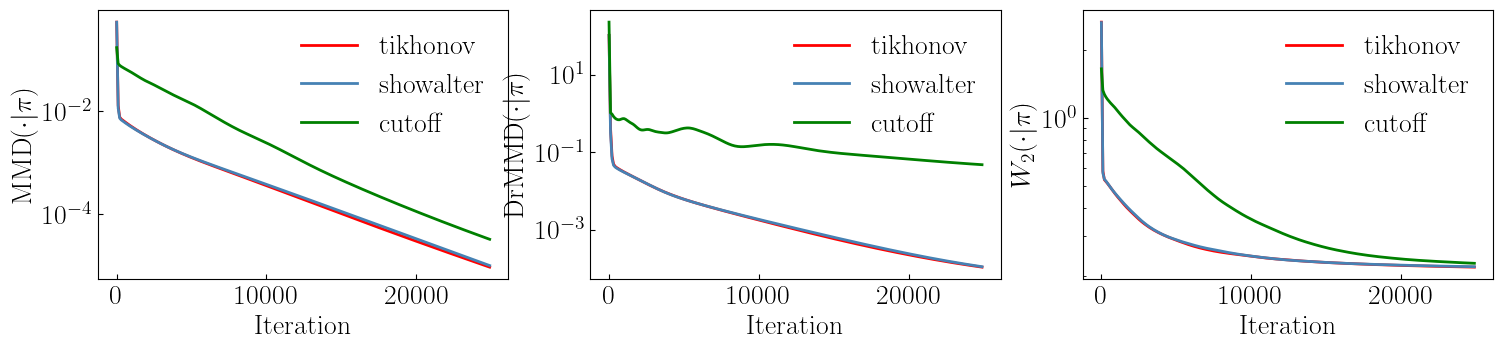

In [68]:

x_ticks = jnp.arange(0, 100* T, 100)

labels = {'mmd': r'$\text{MMD}(\cdot | \pi)$',
          'chard': r'$\text{DrMMD}(\cdot | \pi)$',
          'wass': r'$W_2(\cdot | \pi)$'}


fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))
for i, distance in enumerate(wasserstein_distance_all.keys()):
    axs[i].set_xlabel('Iteration')
    axs[i].set_ylabel(labels[distance])
    for method in wasserstein_distance_all[distance].keys():
        axs[i].plot(x_ticks, wasserstein_distance_all[distance][method], color=color_dict[method], label=method)
    axs[i].set_yscale('log')
    axs[i].legend()
plt.show()